This example tests whether an approach that uses empirical characteristic functions (ECFs) can detect differences in models with different variance of sampled parameters. 

In [1]:
from matplotlib import pyplot as plt
import ipywidgets as ipw
from IPython.display import display
import numpy as np
import pandas as pd

from stochastic_models import model_sir
from stochastic_tests import Test
import stochastic_repro as sr

t_fin = 10.0
num_steps = 100
test_kwargs = dict(t_fin=t_fin, 
                   num_steps=num_steps, 
                   sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)], 
                   trials=[100, 500, 1000, 5000, 10000])

beta_mean = 2.0E-6
beta_stdev = beta_mean / 10
beta1_stdev = beta_stdev
beta2_stdev = beta_stdev * 1.25

test1 = Test(model=model_sir({'beta': ('norm', (beta_mean, beta1_stdev))}), stochastic=False, **test_kwargs)
test2 = Test(model=model_sir({'beta': ('norm', (beta_mean, beta2_stdev))}), stochastic=False, **test_kwargs)
tests = [test1, test2]

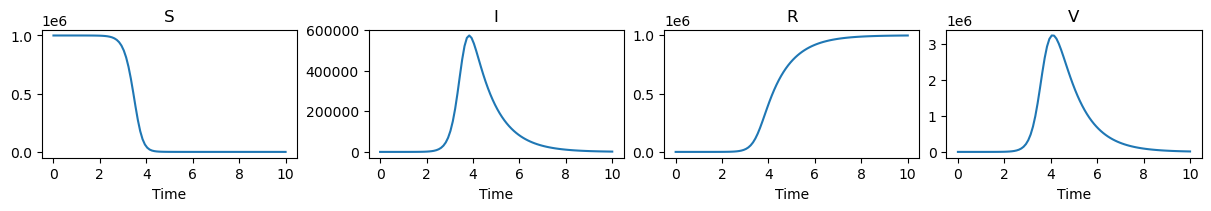

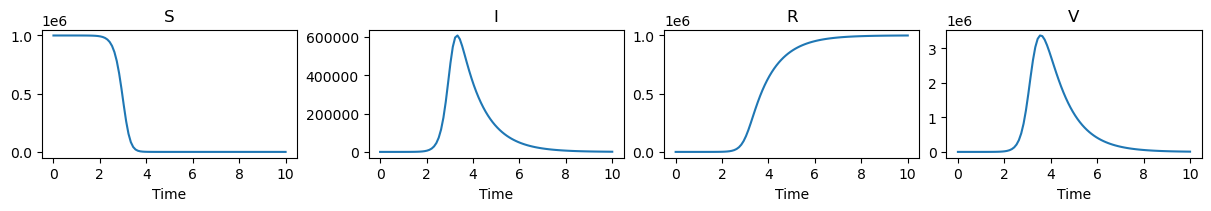

In [2]:
for test in tests:
    test.execute_deterministic()
    _ = test.plot_results_deterministic()

In [3]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

for test in tests:
    test.execute_stochastic(label)
_ = out.clear_output()

Output()

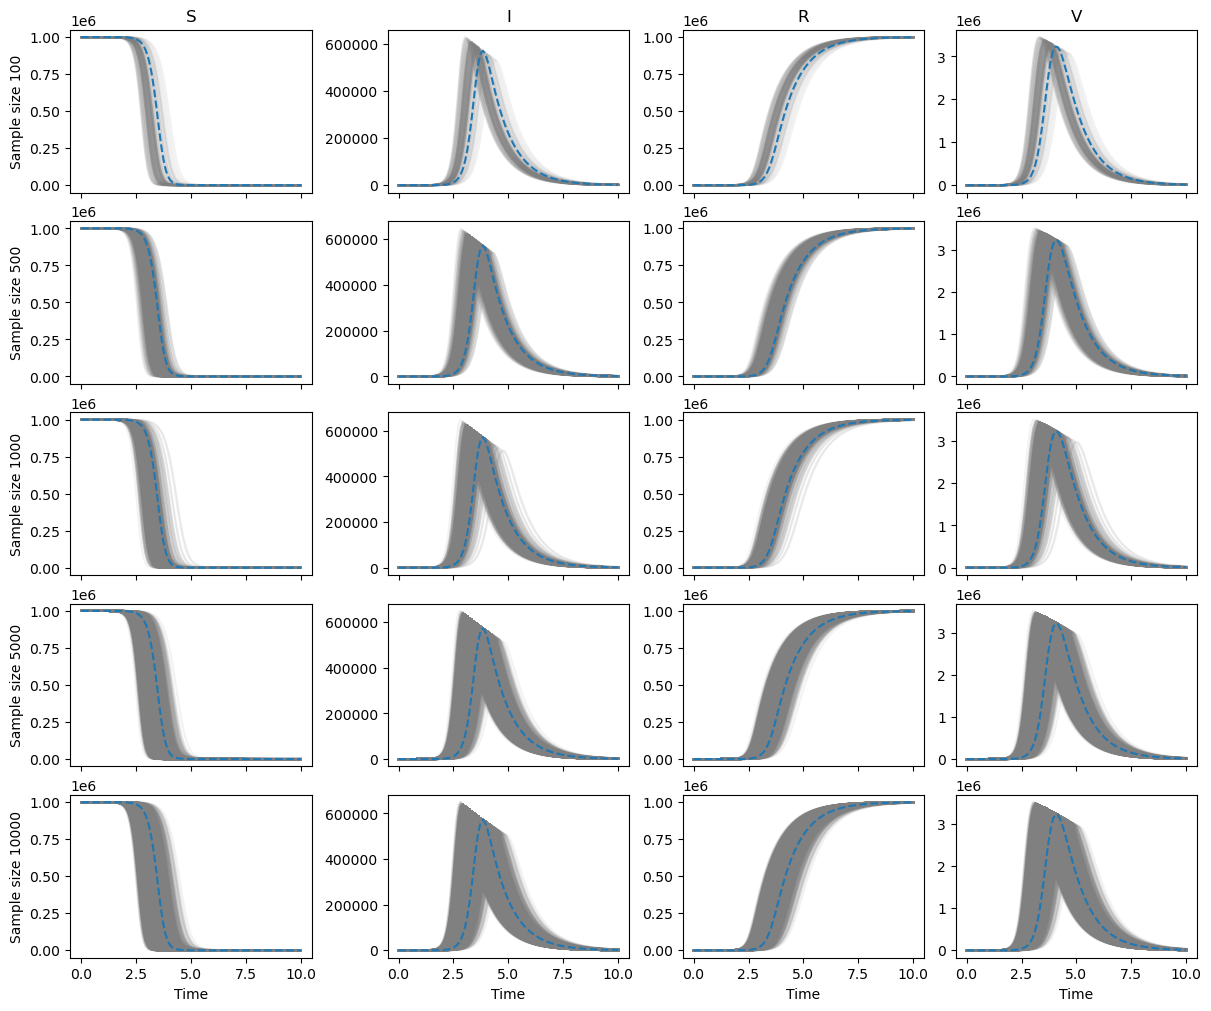

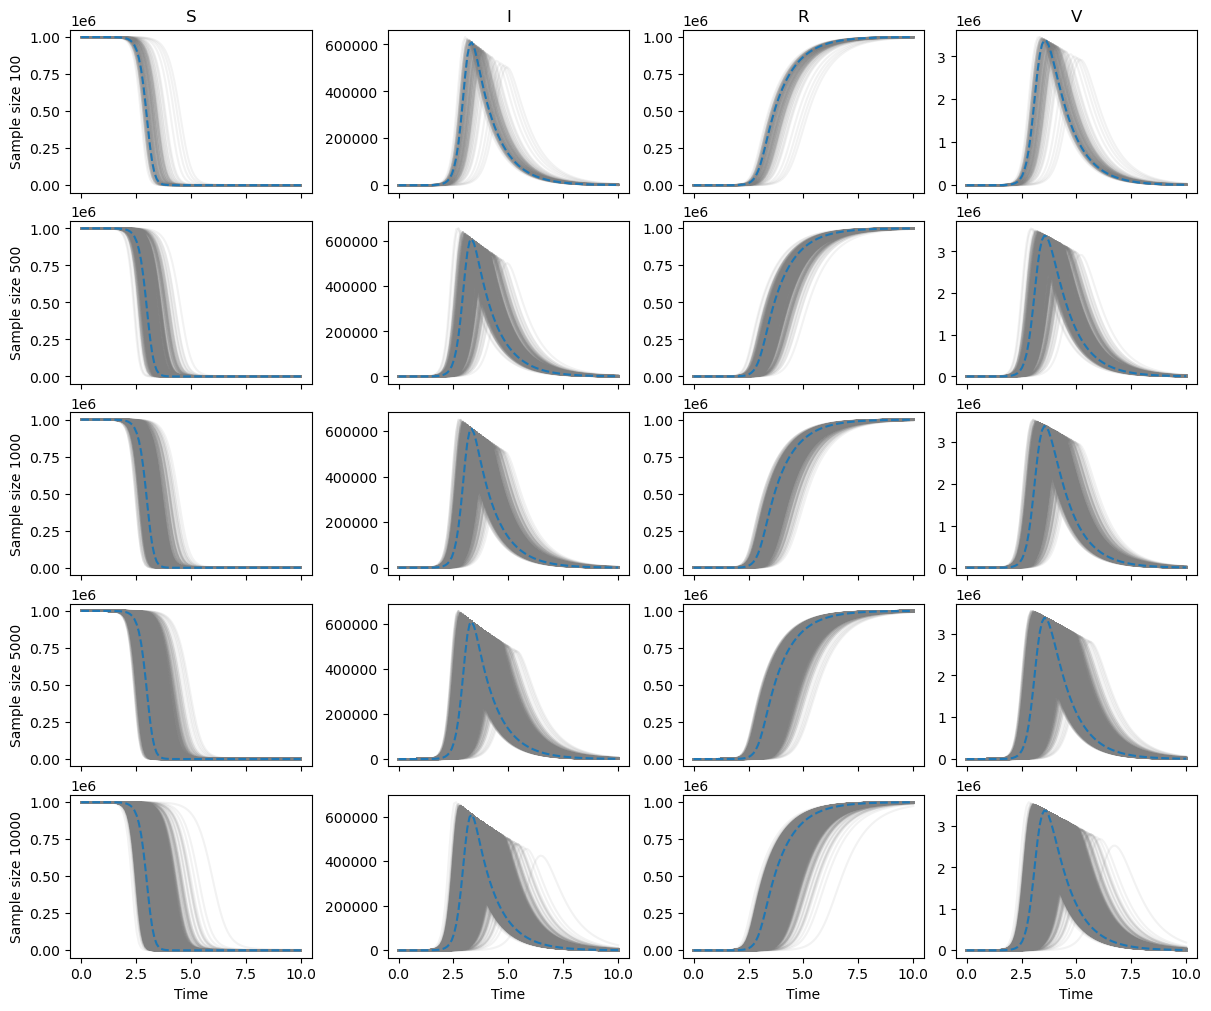

In [4]:
for test in tests:
    _ = test.plot_results_stochastic()

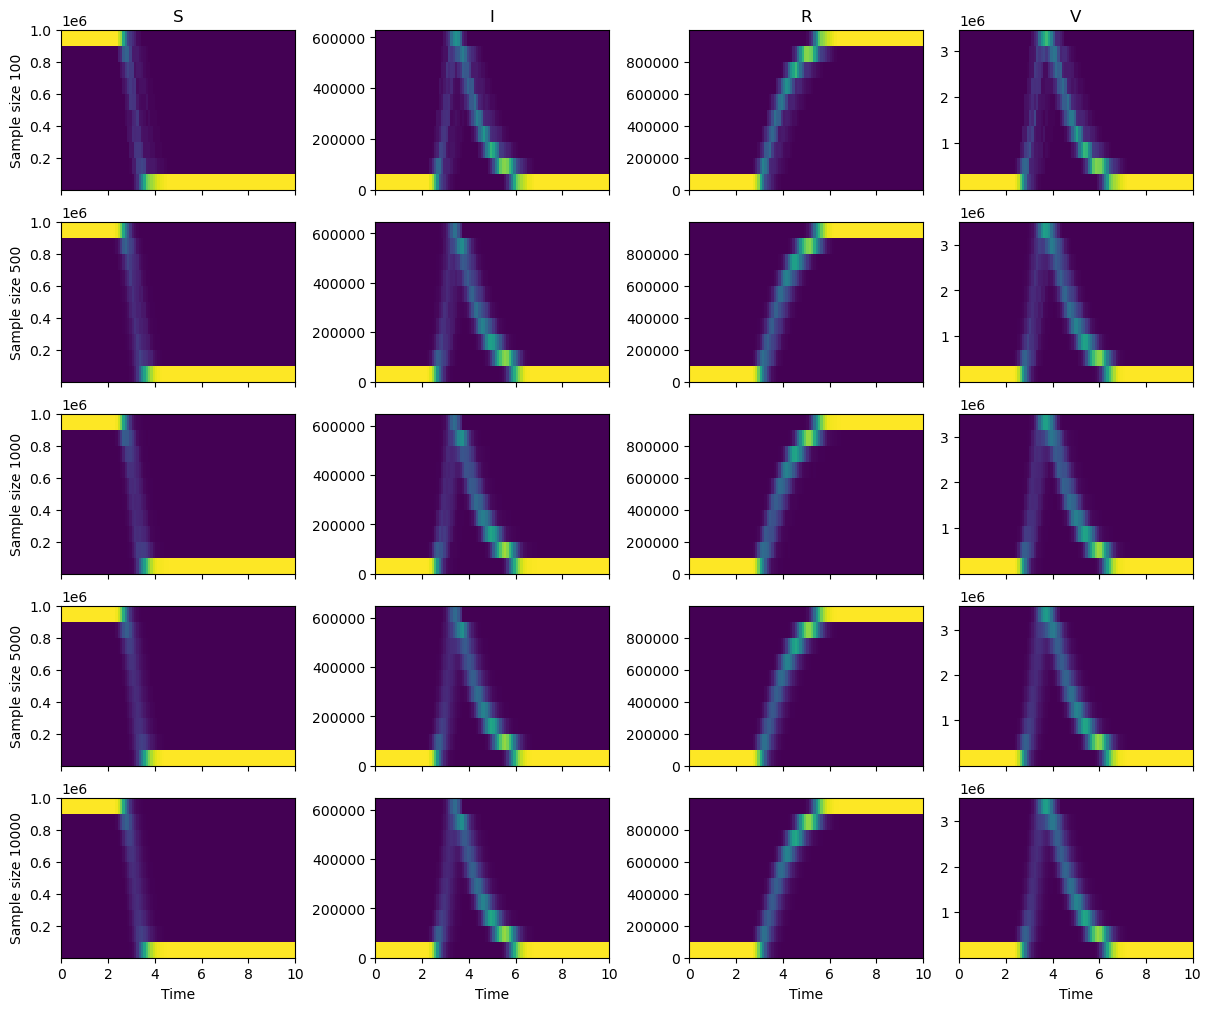

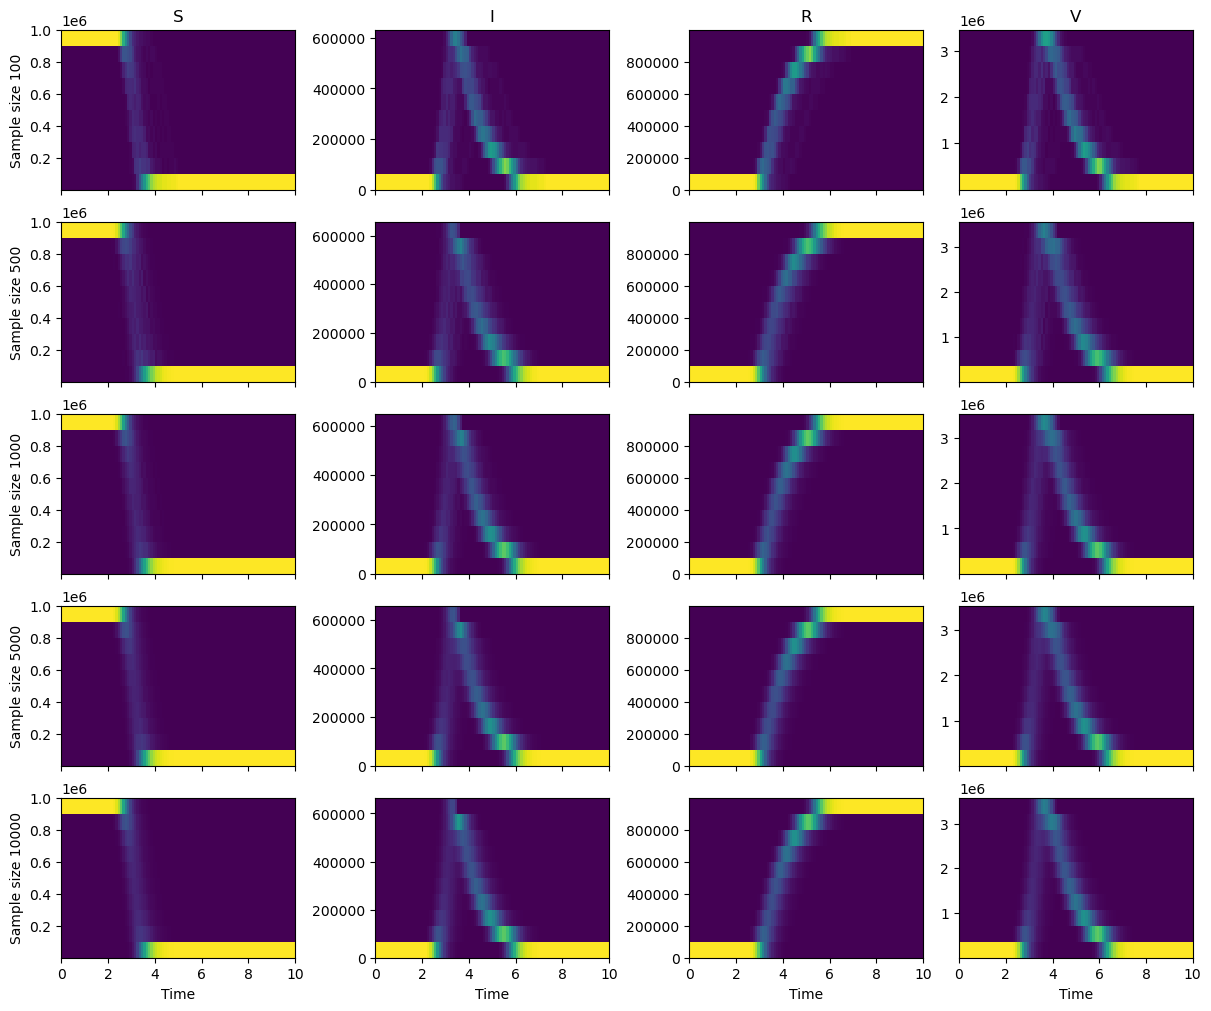

In [5]:
for test in tests:
    _ = test.plot_distributions()

C:\Users\timothy.sego\AppData\Local\miniconda3\envs\stoch_repro\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


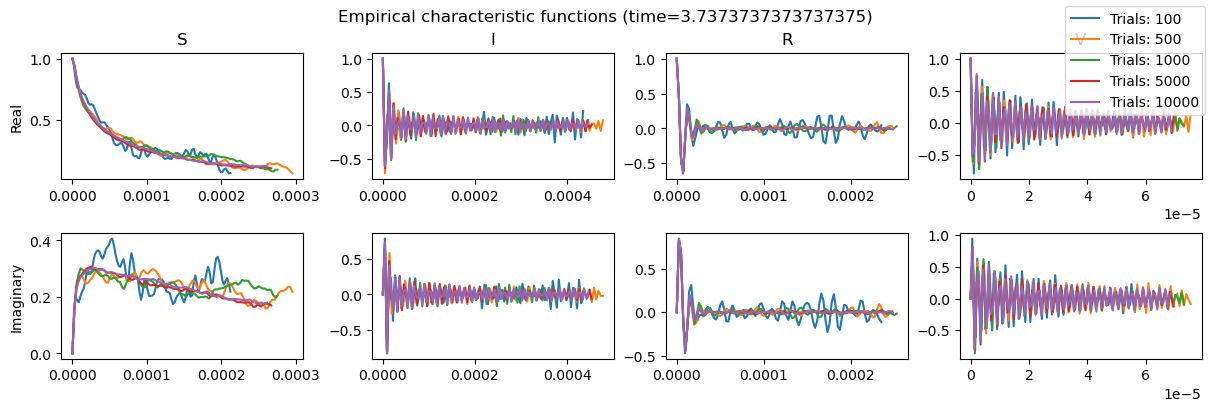

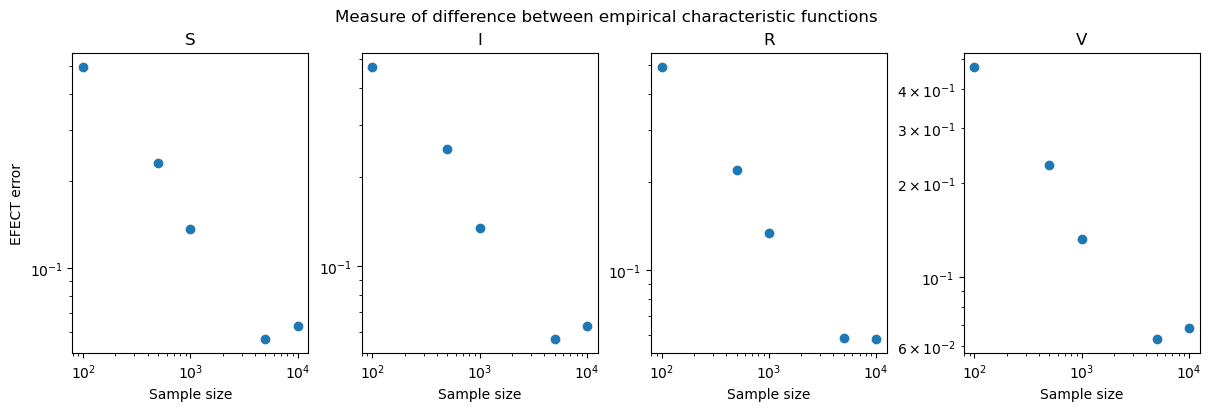

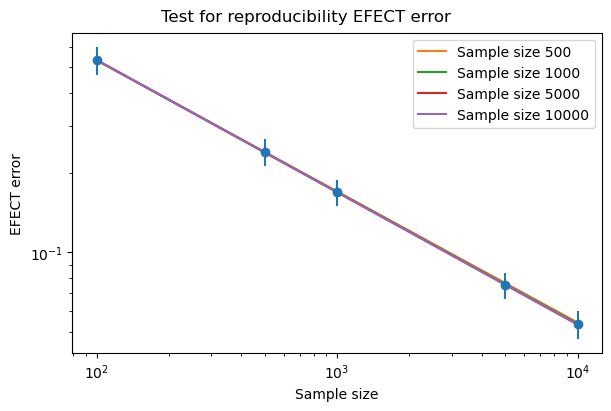

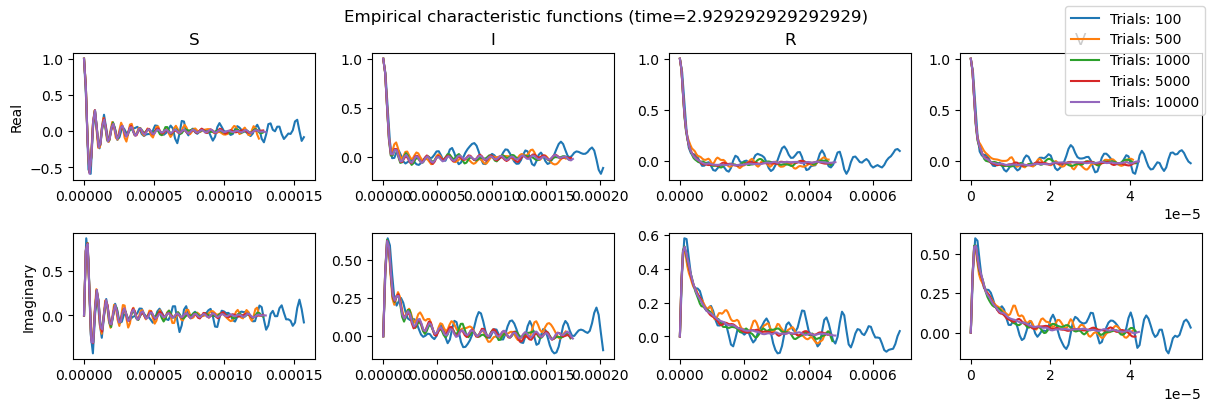

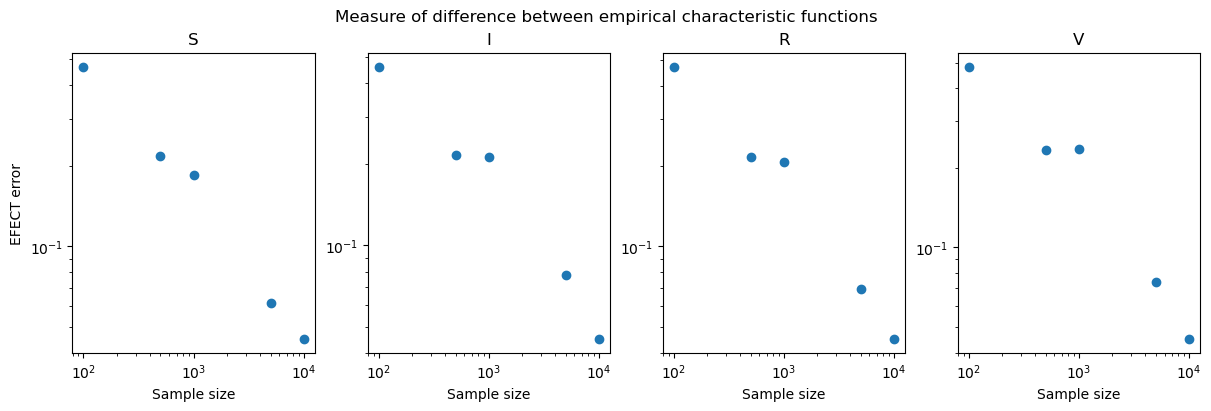

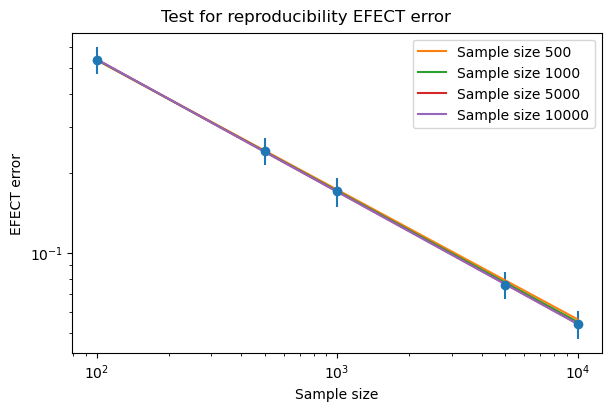

In [6]:
for test in [test1, test2]:
    test.find_ecfs()
    test.measure_ecf_diffs()
    test.plot_ecf(test.max_ks_stat_time(test.trials[-1]))
    test.plot_ecf_diffs()
    test.test_sampling(err_thresh=1E-3)
    test.generate_ecf_sampling_fits()
    _, ax = test.plot_ecf_sampling_fits(test.plot_ecf_sampling())
    _ = ax.legend()

test1.save('proto_compare_6_test1.json')
test2.save('proto_compare_6_test2.json')

Comparing the converged ECF of the two models, we should find that they are always quantifiably different since their models have different parameters.

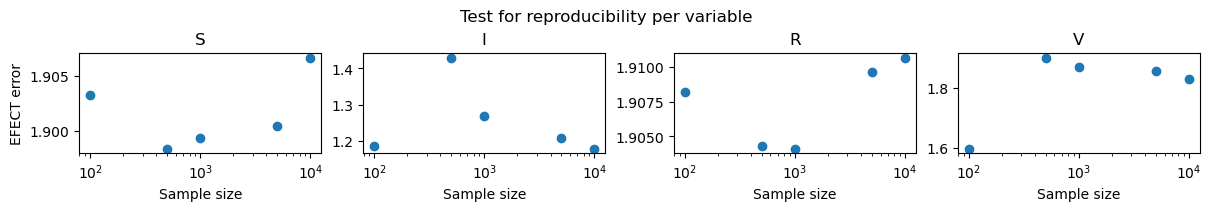

In [7]:
ecf_diff = sr.measure_ecf_diff_sets(test1.ecf, test2.ecf)

fig, ax = plt.subplots(1, len(test1.model.results_names), sharey=False, figsize=(12.0, 2.0), layout='compressed')
for i, name in enumerate(test1.model.results_names):
    ax[i].scatter(test1.trials, [max([el[name] for el in ecf_diff[trial]]) for trial in test1.trials])
    ax[i].set_xlabel('Sample size')
    ax[i].set_xscale('log')
    ax[i].set_title(name)
ax[0].set_ylabel('EFECT error')
_ = fig.suptitle('Test for reproducibility per variable')

Testing for how well the method can detect differences in variance of model parameters. 

Output()

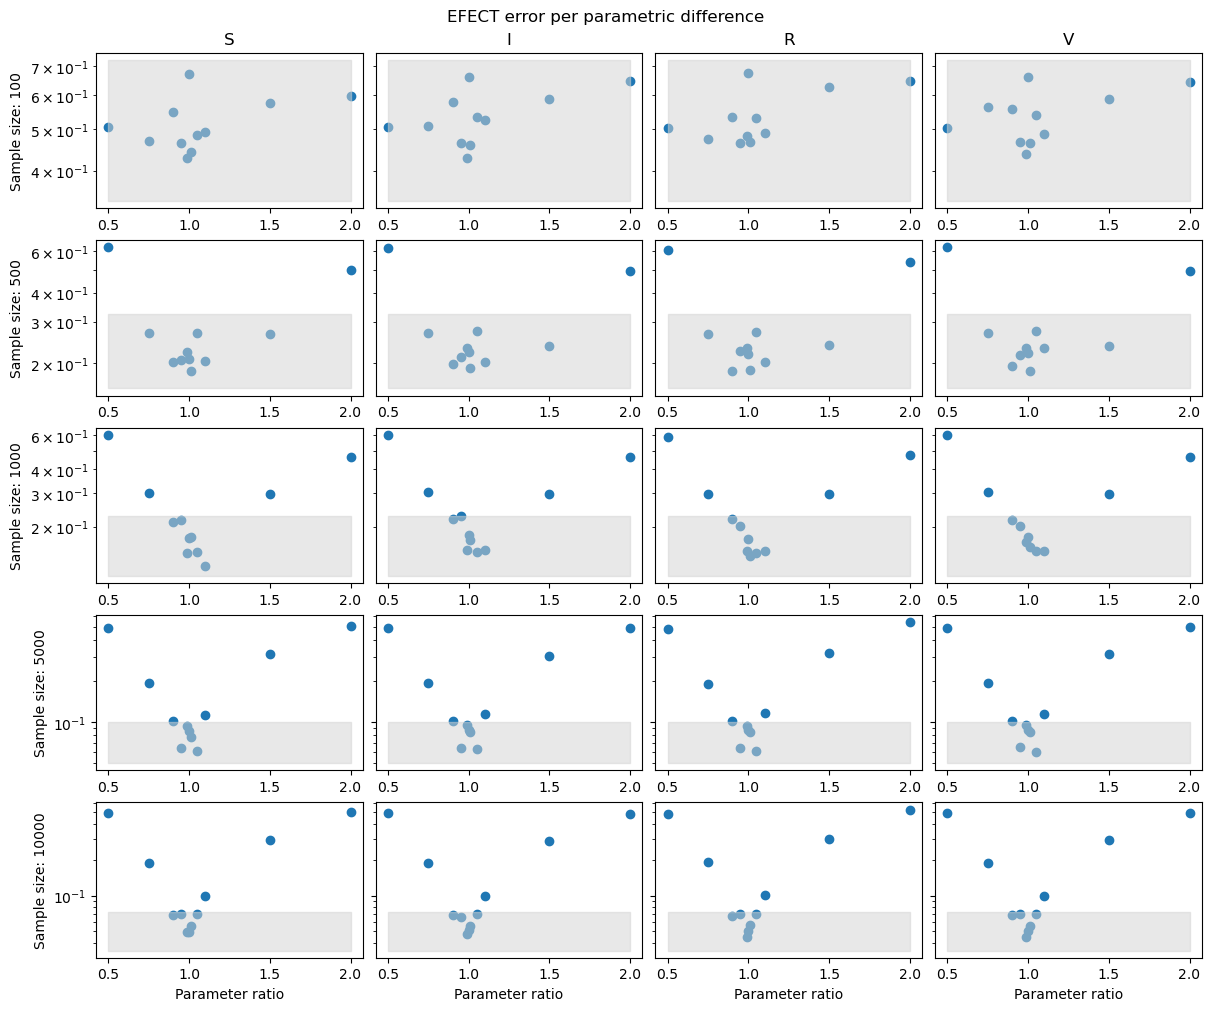

In [8]:
beta_fact = [0.5, 0.75, 0.9, 0.95, 0.99, 1.0, 1.01, 1.05, 1.1, 1.5, 2.0]
beta_comp = list()
test_test_kwargs = test_kwargs.copy()
test_test_kwargs['trials'] = [int(t / 2) for t in test_kwargs['trials']]

label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

# Make half-size tests
test1_sims_hs = {}
ecf_eval_info = {}
for trials in test1.trials:
    ht = int(trials / 2)
    simset = sr.SimSet(model=test1.model, num_trials=ht, stochastic=False, num_steps=test_kwargs['num_steps'], t_fin=test_kwargs['t_fin'])
    simset.results = {k: v[:ht, :] for k, v in test1.sims_s[trials].results.items()}
    simset.results_time = test1.sims_s[trials].results_time
    test1_sims_hs[ht] = simset
    ecf_eval_info[ht] = test1.ecf_eval_info[trials]
ecf1 = sr.generate_ecfs(test1_sims_hs, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)

for bf in beta_fact:
    label.value = f'Factor: {bf}...'

    betatest_stdev = beta_stdev * bf
    test = Test(model=model_sir({'beta': ('norm', (beta_mean, betatest_stdev))}), stochastic=False, **test_test_kwargs)
    test.execute_stochastic()
    ecf2 = sr.generate_ecfs(test.sims_s, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)
    beta_comp.append(sr.measure_ecf_diff_sets(ecf1, ecf2))

out.clear_output()

fig, ax = plt.subplots(len(test1.trials), len(test1.model.results_names), sharey='row', figsize=(12.0, 2.0 * len(test1.trials)), layout='compressed')
for i, trial in enumerate(test1.trials):
    for j, name in enumerate(test1.model.results_names):
        ax[i][j].scatter(beta_fact, [max([el[name] for el in diff[int(trial / 2)]]) for diff in beta_comp])
        
        avg = np.average(test1.ks_stats_sampling[trial])
        err = np.std(test1.ks_stats_sampling[trial]) * 3
        ax[i][j].fill_between(beta_fact, avg - err, avg + err, color='lightgray', alpha=0.5)
        ax[i][j].set_yscale('log')

for i, name in enumerate(test1.model.results_names):
    ax[0][i].set_title(name)
    ax[-1][i].set_xlabel('Parameter ratio')
for i, trial in enumerate(test1.trials):
    ax[i][0].set_ylabel(f'Sample size: {trial}')
_ = fig.suptitle('EFECT error per parametric difference')

In [9]:
summary_entries = ['Average', 'St. dev.']
df_summary = pd.DataFrame(index=test_kwargs['trials'], columns=summary_entries)
eval_entries = ['Sample size', 'Scaling factor', 'EFECT error', 'Standardized error', 'Acceptance p-value']
data_eval = []

for sample_size in test_test_kwargs['trials']:
    avg = np.average(test1.ks_stats_sampling[sample_size * 2])
    std = np.std(test1.ks_stats_sampling[sample_size * 2])
    df_summary.loc[sample_size * 2, 'Average'] = avg
    df_summary.loc[sample_size * 2, 'St. dev.'] = std

    err = [max([max(d.values()) for d in diff[sample_size]]) for diff in beta_comp]
    q2 = (sample_size + 1) / sample_size * np.var(test1.ks_stats_sampling[sample_size * 2], ddof=1)
    lam2 = [(e - avg) * (e - avg) / q2 for e in err]
    pr = [np.floor((sample_size + 1) / sample_size * ((sample_size - 1) / l2 + 1)) / (sample_size + 1) for l2 in lam2]
    for i in range(len(err)):
        if pr[i] > 1.0 or err[i] < avg:
            pr[i] = 1.0

    for i, bf in enumerate(beta_fact):
        data_eval.append((sample_size * 2, bf, err[i], (err[i] - avg) / std, min(1, pr[i])))

display(df_summary)
mi_eval = pd.MultiIndex.from_frame(pd.DataFrame(data_eval, columns=eval_entries))
df_eval = mi_eval.to_frame()
display(df_eval)

,Average,St. dev.
100,0.532317,0.063978
500,0.239781,0.027788
1000,0.169064,0.019458
5000,0.075267,0.008524
10000,0.053613,0.006367


Sample size  \
Sample size Scaling factor EFECT error Standardized error Acceptance p-value                
100         0.50           0.506043    -0.410668          1.000000                    100   
            0.75           0.562135     0.466072          1.000000                    100   
            0.90           0.577836     0.711490          1.000000                    100   
            0.95           0.466985    -1.021148          1.000000                    100   
            0.99           0.482549    -0.777887          1.000000                    100   
            1.00           0.674777     2.226709          0.215686                    100   
            1.01           0.468327    -1.000175          1.000000                    100   
            1.05           0.539476     0.111905          1.000000                    100   
            1.10           0.526704    -0.087723          1.000000                    100   
            1.50           0.625663     1.459028          0.470588                    100   
            2.00           0.646983     1.792270          0.313725                    100   
500         0.50           0.622657     13.778619         0.007968                    500   
            0.75           0.270513     1.105974          0.820717                    500   
            0.90           0.203559    -1.303518          1.000000                    500   
            0.95           0.226454    -0.479585          1.000000                    500   
            0.99           0.232577    -0.259235          1.000000                    500   
            1.00           0.223063    -0.601632          1.000000                    500   
            1.01           0.190548    -1.771724          1.000000                    500   
            1.05           0.274336     1.243560          0.649402                    500   
            1.10           0.232376    -0.266474          1.000000                    500   
            1.50           0.267271     0.989295          1.000000                    500   
            2.00           0.536958     10.694583         0.011952                    500   
1000        0.50           0.602864     22.294029         0.003992                   1000   
            0.75           0.303632     6.915784          0.021956                   1000   
            0.90           0.219667     2.600577          0.149701                   1000   
            0.95           0.228025     3.030108          0.109780                   1000   
            0.99           0.166010    -0.156985          1.000000                   1000   
            1.00           0.181685     0.648585          1.000000                   1000   
            1.01           0.177614     0.439404          1.000000                   1000   
            1.05           0.149205    -1.020599          1.000000                   1000   
            1.10           0.151415    -0.907032          1.000000                   1000   
            1.50           0.295274     6.486239          0.023952                   1000   
            2.00           0.475556     15.751379         0.005988                   1000   
5000        0.50           0.492841     48.987138         0.000800                   5000   
            0.75           0.193578     13.879571         0.005598                   5000   
            0.90           0.102593     3.205757          0.097561                   5000   
            0.95           0.065739    -1.117727          1.000000                   5000   
            0.99           0.094844     2.296687          0.190324                   5000   
            1.00           0.086857     1.359684          0.542583                   5000   
            1.01           0.084469     1.079546          0.860456                   5000   
            1.05           0.063129    -1.423921          1.000000                   5000   
            1.10           0.116311     4.815023          0.043583             